*Note: I remade this post to address minor inconsistencies and what I perceived to be a lack of attention to units of some of the physical quantities. The updated post may be found [here](simple-pupil-function-calculations.html).

# Simple simulations of microscope pupil functions
[In one of my recent publications](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0142949), my co-authors and I investigated an aberration that is especially pernicious for 3D localization microscopies such as [STORM and PALM](https://en.wikipedia.org/wiki/Super-resolution_microscopy#STORM.2C_PALM_and_FPALM). This aberration results in a dependence of the perceived position of a single, fluorescent molecule on its axial position within the focal plane of a microscope. To identify a possible source for this aberration, I employed a phase retrieval algorithm to obtain the pupil function of the microscope. I then decomposed the pupil function into a number of orthogonal polynomial terms and identified the specific terms that led to the aberration that we observed. In this case, terms associated with [coma](https://en.wikipedia.org/wiki/Coma_%28optics%29) were the culprits.

So why exactly is coma bad for 3D localization microscopy? Unfortunately, we did not have time to go into the subtleties question in the publication due deadlines on the revisions. Luckily, the internet is a wonderful tool for explaining some of these ideas outside of the formal structure of an academic paper, which is what I will do here.

To answer the question, we first require a bit of knowledge about Fourier optics. The purpose of this post is to describe what a pupil function is and how it can be easily simulated on a computer with Python. We'll then see how we can use it to model a simple aberration: defocus. A future post will explain why coma is bad for 3D localization microscopy using the foundations built upon here.

## Pupil Function Basics
The pupil function of a microscope (and really, of any optical system) is an important tool for analyzing the aberrations present in the system. The pupil function is defined as the two dimensional Fourier transform of the image of an isotropic point source. [The two dimensional Fourier transform](http://mathworld.wolfram.com/FourierTransform.html) of a function of two variables x and y is expressed as 

$$F \left( k_x, k_y \right) = \iint f \left( x, y \right) \exp \left[ -j \left( k_{x}x + k_{y}y \right) \right] dx dy$$

(I was originally trained as an engineer, so I tend to use 'j' for the imaginary number more than 'i'.) The inverse Fourier transform converts \\(F \left( k_x, k_y \right)\\) back into \\(f \left( x, y \right)\\) and is given by 

$$f \left( x, y \right) = \iint F \left( k_x, k_y \right) \exp \left[ j \left( k_{x}x + k_{y}y \right) \right] dk_x dk_y$$

In this case, \\(x\\) and \\(y\\) are variables representing 2D coordinates in the image plane and \\(k_x\\) and \\(k_y\\) are the spatial frequencies. \\(f \left( x, y \right)\\) and \\(F \left( k_x, k_y \right)\\) are known as Fourier transform pairs.

An isotropic point source is an idealized source of electromagnetic radiation that emits an equal intensity in all directions. Strictly speaking, real sources such as atoms and molecules are dipoles and not isotropic emitters. This assumption is however a good model for collections of many fluorescent molecules possessing dipole moments that are all pointing in different directions and that are smaller than the wavelength of light because the molecules' individual emission patterns average out. It is also a good approximation for a dipole whose moment is randomly reorienting in many directions during an image acquisition due to thermally-induced rotational diffusion.

The image of a point source is known as the [point spread function (PSF)](https://en.wikipedia.org/wiki/Point_spread_function) of the microscope. In signal processing, it's known as a two dimensional impulse response.

[The equation](http://www.msg.ucsf.edu/agard/Publications/148-Agard-JMicrosc-2004.pdf) that relates the image of the isotropic point source to the pupil function \\(P \left( k_x, k_y \right)\\) is

$$\text{PSF}_{\text{A}} \left( x, y \right) = \iint P \left( k_x, k_y \right) \exp \left[ -j \left( k_{x}x + k_{y}y \right) \right] dx dy$$

The subscript `A` on the PSF stands for *amplitude* and means that we are working with the electric field, not the [irradiance](https://en.wikipedia.org/wiki/Irradiance). The irradiance, which is what a camera or your eye measures, is proportional to the absolute square of \\(\text{PSF}_{\text{A}}\\). In words, the above equation restates the definition above: the pupil function and the amplitude PSF are Fourier transform pairs.

## Simulating Diffraction Limited Pupil Functions and PSF's
We can simulate how an aberration affects the image of a point source by simulating an aberrated pupil function and computing the Fourier transform above to get the amplitude PSF. The easiest model to simulate is based on scalar diffraction theory, which means that we ignore the fact that the electromagnetic radiation is polarized (i.e. a vector) and treat it as a scalar quantity instead. Even though this is an approximation, it still can give us a good idea about the fundamental physics involved.

To perform the simulation, we must first discretize the continuous quantities in the Fourier transform. We'll model \\(\text{PSF}_{\text{A}}\\) and \\(P \left( k_x, k_y \right)\\) as discrete scalar quantities on 2D grids and perform a [fast Fourier transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) to turn the pupil function into the PSF.

In [1]:
# Load scientific Python libraries
%pylab
%matplotlib inline
from scipy.fftpack import fft2
from scipy.fftpack import fftshift, ifftshift

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.style.use('dark_background')
plt.rcParams['image.cmap'] = 'plasma' 

Let's start by setting up the image plane and spatial frequency grids. If we work with square images, then the primary quantity we have to set a value for is the number of pixels. The number of pixels that we choose to simulate is a bit arbitrary, though as we'll see later, it determines the spacing of the discretized pupil function coordinates.

In [3]:
imgSize = 513 # Choose an odd number to ensure rotational symmetry about the center

The rest of the important parameters for setting up the grids are determined by your microscope.

In [4]:
wavelength = 0.68 # microns
NA         = 1.4  # Numerical aperture of the objective
nImmersion = 1.51 # Refractive index of the immersion oil
pixelSize  = 0.1  # microns, typical for microscopes with 60X--100X magnifications

Now we have enough information to define the grid on which the pupil function lies.

In [5]:
kMax = 2 * pi / pixelSize # Value of k at the maximum extent of the pupil function
kNA  = 2 * pi * NA / wavelength
dk   = 2 * pi / (imgSize * pixelSize)

When working with discrete Fourier transforms, a common question that arises is "What are the units of the Fourier transform variable?" We can answer this question by these rules:

> \\(k_{Max} \propto \frac{1}{dx}\\)

> \\(x_{Max} \propto \frac{1}{dk}\\)

These two rules are just a manifestation of the [Nyquist-Shannon sampling criterion](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem): the maximum spatial frequency \\( k\_{Max} \\) is determined by the inverse of the sampling period in space \\(dx\\), while the maximum size \\(x\_{Max}\\) of the signal is proportional to the inverse of the period of spatial frequency samples \\(dk\\). This is why the maximum spatial frequency above is \\(2 \pi / \text{pixelSize}\\). I will go into more detail on this in a later post.

The pupil function of a microscope is non-zero for values of \\(\left( k_x, k_y \right)\\) such that \\(k_x^2 + k_y^2 \leq \frac{2 \pi NA}{\lambda}\\). The quantity \\(\frac{2 \pi NA}{\lambda}\\) is represented by `kNA` above. The size of a pixel `dk` in spatial frequency units (radians per distance) is inversely proportional to the maximum size of the image in pixels, or `imgSize * pixelSize`. Likewise, the size of a pixel in microns is proportional to the inverse of the maximum size of the pupil function in spatial frequencies. This is just a manifestation of the properties of Fourier transform pairs.

In [6]:
kx = np.arange((-kMax + dk) / 2, (kMax + dk) / 2, dk)
ky = np.arange((-kMax + dk) / 2, (kMax + dk) / 2, dk)
KX, KY = np.meshgrid(kx, ky) # The coordinate system for the pupil function
print('kmin : {0}'.format(kx[0]))
print('kmax : {0}'.format(kx[-1]))
print('Size of kx : {0}'.format(kx.size))


kmin : -31.354686913020938
kmax : 31.354686913020036
Size of kx : 513


Now that the coordinate system for the pupil function is setup, we can go ahead and define the pupil function for an *aberration free* microscope. First, we need to create a mask whose value is one inside a circle whose extent is set by the microscope's NA and zero outside it. This mask is used to create a circular pupil.

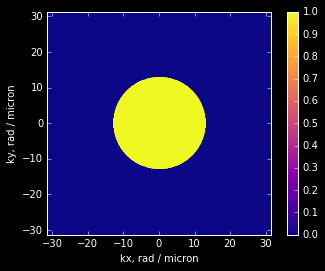

In [7]:
maskRadius = kNA / dk # Radius of amplitude mask for defining the pupil
maskCenter = np.floor(imgSize / 2)
W, H       = np.meshgrid(np.arange(0, imgSize), np.arange(0, imgSize))
mask       = np.sqrt((W - maskCenter)**2 + (H- maskCenter)**2) < maskRadius

plt.imshow(mask, extent = (kx.min(), kx.max(), ky.min(), ky.max()))
plt.xlabel('kx, rad / micron')
plt.ylabel('ky, rad / micron')
plt.colorbar()
plt.show()

The pupil function is a complex quantity, which means it has both real and imaginary components. The unaberrated pupil function for an on-axis point source simply has a uniform phase and amplitude equal to one inside the mask.

In [8]:
amp   = np.ones((imgSize, imgSize)) * mask
phase = 2j * np.pi * np.ones((imgSize, imgSize))
pupil = amp * np.exp(phase)

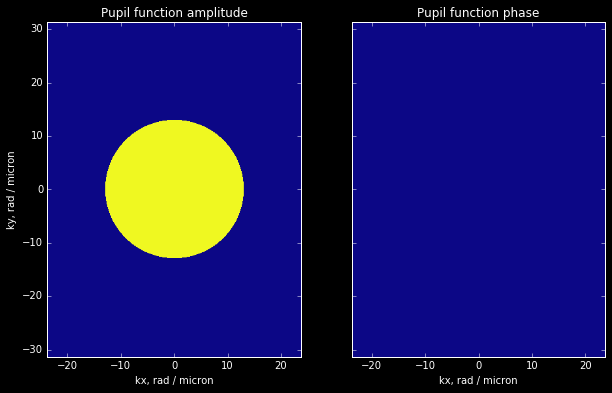

In [9]:
fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = (10,6))
img0 = ax0.imshow(amp, extent = ((kx.min(), kx.max(), ky.min(), ky.max())))
ax0.set_title('Pupil function amplitude')
ax0.set_xlabel('kx, rad / micron')
ax0.set_ylabel('ky, rad / micron')

img1 = ax1.imshow(np.imag(phase), extent = ((kx.min(), kx.max(), ky.min(), ky.max())))
ax1.set_title('Pupil function phase')
ax1.set_xlabel('kx, rad / micron')
plt.show()

The amplitude PSF for the isotropic point source is simply the Fourier transform of this pupil function. The camera, which measures irradiance and not electric field, sees the absolute square of the amplitude PSF.

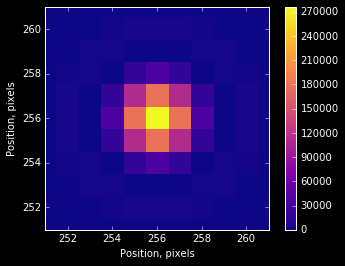

In [10]:
psfA_Unaberrated = fftshift(fft2(ifftshift(pupil))) * dk**2
psf              = psfA_Unaberrated * np.conj(psfA_Unaberrated) # PSFA times its complex conjugate

zoomWidth = 5 # pixels

# It is important to set interpolation to 'nearest' to prevent smoothing
img = plt.imshow(np.real(psf), interpolation = 'nearest')
plt.xlim((np.floor(imgSize / 2) - zoomWidth, np.floor(imgSize / 2) + zoomWidth))
plt.ylim((np.floor(imgSize / 2) - zoomWidth, np.floor(imgSize / 2) + zoomWidth))
plt.xlabel('Position, pixels')
plt.ylabel('Position, pixels')
plt.colorbar(img)
plt.show()

This is a simulated image of an on-axis, in-focus, isotropic point source from an unaberrated pupil with an object-space pixel size of 100 nm.

The image is also a decent approximation of what a real single molecule image looks like in localization microscopies. I say *decent* because a single molecule will have a dipolar emission profile, not isotropic. Additionally, the scalar-diffraction model used here ignores polarization effects. Finally, a real image will have noise, which would be reflected as a random variation in the signal of each pixel.

Let's see how a line profile through the center of the image looks relative to the profile of the [Airy disk](https://en.wikipedia.org/wiki/Airy_disk), which is the mathematical solution to the diffraction pattern from a circular aperture in scalar diffraction theory. The Airy disk is given by

$$I \left( X \right) = I_{0} \left[ \frac{2J_{1} \left( X \right)}{X} \right]^2$$

where \\(J_{1} \left( X \right) \\) is the Bessel function of the first kind and order 1 and \\( X = \frac{2 \pi r  (\text{NA})}{\lambda} \\). Here, \\(r\\) is the distance from the center of the image plane, so we can easily convert it to pixels.

Because the pupil of the microscope is circular and unaberrated, it is also the solution for PSF of the microscope.

/home/douglass/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


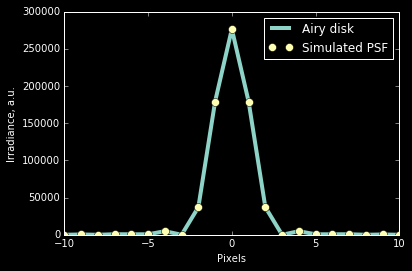

In [11]:
from scipy.special import j1 as bessel1
px   = np.arange(-10, 11) # pixels
x    = 2 * np.pi * px * NA * pixelSize / wavelength 
airy = np.max(np.real(psf)) * (2 * bessel1(x) / x)**2

# Fix point at x = 0 where divide-by-zero occurred
airy[int(np.floor(x.size / 2))] = np.max(np.real(psf))

# Take a line profile through the center of the simulated PSF
lineProfile = np.real(psf[int(np.floor(imgSize / 2)), int(np.floor(imgSize / 2) - 10) : int(np.floor(imgSize / 2) + 11)])

plt.plot(px, airy,             linewidth = 4,  label = 'Airy disk')
plt.plot(px, lineProfile, 'o', markersize = 8, label = 'Simulated PSF')
plt.xlabel('Pixels')
plt.ylabel('Irradiance, a.u.')
plt.legend()
plt.show()

The simulated PSF agrees well with the scalar diffraction theory, demonstrating that we have correctly simulated the microscope's PSF from an unaberrated pupil function.

## Defocus
Now that we can simulate the diffraction-limited image of an *in-focus* isotropic point source, let's add some defocus to demonstrate what the PSF would look like as the camera or sample is scanned along the axial direction.

Defocus can be added in numerous ways. One is to multiply our pupil function by the phase aberration for defocus, which is usually modeled as a parabolic phase aberration in the pupil coordinates. However, [as I explained in a previous post](http://kmdouglass.github.io/posts/beware-the-paraxial-approximation-in-microscopy.html), this is an approximate model for defocus and fails for large numerical apertures.

Another simple way is to propagate the plane wave angular spectrum in the image plane to nearby planes. This relatively easy method is used in a well-known microscopy paper ([Hanser, 2004](http://onlinelibrary.wiley.com/doi/10.1111/j.0022-2720.2004.01393.x/abstract)) and involves multiplying the pupil function by a defocus kernel before performing the Fourier transform.

$$\text{PSF}_{\text{A}} \left( x, y, z \right) = \iint P \left( k_x, k_y \right) \exp \left( j k_{z} z \right) \exp \left[ -j \left( k_{x}x + k_{y}y \right) \right] dx dy$$

Here, \\(k_z = \sqrt{\left( 2 \pi n / \lambda \right)^2 - k_x^2 - k_y^2}\\). The defocus kernel essentially shifts the phase of each plane wave with pupil coordinates \\(\left( k_x, k_y \right)\\) by an amount that depends on its coordinates and the distance from the image plane \\(z\\).

The above equation means that we can model the PSF behavior as we scan through the focal plane by computing the defocus kernel for different distances from focus. Then, we multiply our perfect pupil by this defocus kernel and compute its Fourier transform to get the amplitude and irradiance PSF's.

In [12]:
# Defocus from -1 micron to + 1 micron
defocusDistance = np.arange(-1, 1.1, 0.1)
defocusPSF      = np.zeros((imgSize, imgSize, defocusDistance.size))

for ctr, z in enumerate(defocusDistance):
    # Add 0j to ensure that np.sqrt knows that its argument is complex
    defocusPhaseAngle   = 1j * z * np.sqrt((2 * np.pi * nImmersion / wavelength)**2 - KX**2 - KY**2 + 0j)
    defocusKernel       = np.exp(defocusPhaseAngle)
    defocusPupil        = pupil * defocusKernel
    defocusPSFA         = fftshift(fft2(ifftshift(defocusPupil))) * dk**2
    defocusPSF[:,:,ctr] = np.real(defocusPSFA * np.conj(defocusPSFA))

And that's it. All we needed to do was multiply pupil by the defocus kernel and compute the FFT like before. Now let's look at a couple of defocused PSF's at different distances from the focal plane.

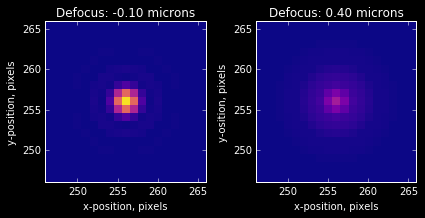

In [13]:
fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2)

zoomWidth = 20 # pixels
indx      = [9, 14] # indexes to defocus distances to plot

# Find the maximum in the in-focus image for displaying PSF's on the correct intensity scale
maxIrradiance = np.max(defocusPSF[:,:,10])

ax0.imshow(defocusPSF[:, :, indx[0]], vmin =0, vmax = maxIrradiance, interpolation = 'nearest')
ax0.set_xlim((np.floor(imgSize / 2) - zoomWidth / 2, np.floor(imgSize / 2) + zoomWidth / 2))
ax0.set_ylim((np.floor(imgSize / 2) - zoomWidth / 2, np.floor(imgSize / 2) + zoomWidth / 2))
ax0.set_xlabel('x-position, pixels')
ax0.set_ylabel('y-position, pixels')
ax0.set_title('Defocus: {0:.2f} microns'.format(defocusDistance[indx[0]]))

ax1.imshow(defocusPSF[:, :, indx[1]], vmin =0, vmax = maxIrradiance, interpolation = 'nearest')
ax1.set_xlim((np.floor(imgSize / 2) - zoomWidth / 2, np.floor(imgSize / 2) + zoomWidth / 2))
ax1.set_ylim((np.floor(imgSize / 2) - zoomWidth / 2, np.floor(imgSize / 2) + zoomWidth / 2))
ax1.set_xlabel('x-position, pixels')
ax1.set_ylabel('y-osition, pixels')
ax1.set_title('Defocus: {0:.2f} microns'.format(defocusDistance[indx[1]]))
plt.tight_layout()
plt.show()

As more and more defocus is added to the pupil, the PSF gets dimmer because the same number of photons are spread out across a larger area of the detector.

In a future post I'll discuss how we can model arbitrary aberrations within this framework. The idea is similar to how defocus is implemented here: you find the phase profile for the aberration, multiply it by the unaberrated pupil, and finally compute the 2D Fourier transform.